In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reset -sf

In [381]:
#### import importlib
import Deproject_v1_0 
from Deproject_test import *
from Deproject_plots import DM_plt_prefs
DM_plt_prefs()
import matplotlib.pyplot as plt
import os
import cProfile
import numpy as np
import builtins
from scipy import sparse as scisp
from scipy import optimize as sopt
from scipy.ndimage import zoom
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from timeit import default_timer as timer
from fast_kde import fast_kde
from astropy.table import QTable
from astropy.io.ascii import read as tableread
import astropy.units as u
import astropy.coordinates as coord
np.random.seed(0)
path = '/home/daniel/DeprojectionProject'

In [4]:
from Deproject_v1_0 import *

%cd ~/DeprojectionProject/DATA

/home/daniel/DeprojectionProject/DATA


In [388]:
def get_vars(folder):
    with open(f'{folder}/log.txt') as log:
        lines = log.readlines()
        n = np.array([int(i) for i in lines[4].split(',')[0][14:][1:-1].split()])
        vmin = np.array([float(i) for i in lines[4].split(',')[1][2:-1].split()])
        dv = np.array([float(i) for i in lines[4].split(',')[2][2:-1].split()])
        vmax = vmin + n*dv

    xbins = np.linspace(vmin[0], vmax[0], n[0]+1)
    ybins = np.linspace(vmin[1], vmax[1], n[1]+1)
    zbins = np.linspace(vmin[2], vmax[2], n[2]+1)

    xc = (xbins[1:] + xbins[:-1])/2
    yc = (ybins[1:] + ybins[:-1])/2
    zc = (zbins[1:] + zbins[:-1])/2

    centers = np.array([xc, yc, zc], dtype=object)

    return n, vmin, dv, vmax, centers

## Create true five_gauss distribution

In [ ]:
vx_bins = np.linspace(vmin[0], vmax[0], n[0]+1)
vy_bins = np.linspace(vmin[1], vmax[1], n[1]+1)
vz_bins = np.linspace(vmin[2], vmax[2], n[2]+1)

vxc = (vx_bins[1:] + vx_bins[:-1]) / 2
vyc = (vy_bins[1:] + vy_bins[:-1]) / 2
vzc = (vz_bins[1:] + vz_bins[:-1]) / 2

"""Given the velocities of each bin we compute the 3D Gaussian value."""

pos = np.stack(np.meshgrid(vxc,vyc,vzc, indexing='ij'),axis=3)

f1 = st.multivariate_normal(mean=np.array([200,     0, 0]), cov=np.diag(np.array([30, 30, 30])**2))
f2 = st.multivariate_normal(mean=np.array([200,  -400, 0]), cov=np.diag(np.array([30, 30, 30])**2))
f3 = st.multivariate_normal(mean=np.array([-200,    0, 0]), cov=np.diag(np.array([30, 30, 30])**2))
f4 = st.multivariate_normal(mean=np.array([-200, -400, 0]), cov=np.diag(np.array([30, 30, 30])**2))
f5 = st.multivariate_normal(mean=np.array([0,    -200, 0]), cov=np.diag(np.array([30, 30, 30])**2))

fv_true = np.prod(dv)*(f1.pdf(pos) + f2.pdf(pos) + f3.pdf(pos) + f4.pdf(pos) + f5.pdf(pos))/5

In [ ]:
plt.pcolormesh(vxc, vyc, fv_true.sum(axis=2).T)

## Load derived five_gauss distribution

In [ ]:
fv_dict = np.load(f'{path}/RUNS/2022-04-29a/mxl_data.npy', allow_pickle=True).item()
# get_fv(fv_dict[list(fv_dict.keys())[-1]], 'xy')

In [ ]:
plt.pcolormesh(vxc,
               vyc,
               np.exp(fv_dict[list(fv_dict.keys())[-1]]).sum(axis=2).T)

In [ ]:
phi_true = np.log(fv_true).ravel()
phi_est = fv_dict[list(fv_dict.keys())[-1]].ravel()

In [549]:
data[:20000].write('wds_small.vot', format='votable')

## Calculate the kvals of five_gauss sample

In [536]:
data = QTable.read('500pc/3sigma/wds.vot', format='votable')
#data = data[data['parallax'] > 0.5*u.mas]
dist = coord.Distance(parallax=data['parallax']*1000)
RA = data['ra']
DEC = data['dec']
plx = data['parallax']
pm_RA = data['pmra'].value*u.mas/u.yr*1000
pm_DEC = data['pmdec'].value*u.mas/u.yr*1000
print("Sample has " + str(len(dist)) + " stars\n")
sample = coord.SkyCoord(ra=RA,
                       dec=DEC,
                       distance=dist,
                       pm_ra_cosdec=pm_RA,
                       pm_dec=pm_DEC,
                       radial_velocity=np.zeros(len(RA))*u.km/u.s,
                       frame='icrs').galactic

Sample has 129675 stars



In [508]:
rhat = sample.spherical.unit_vectors()['distance'].xyz.T
pvals = sample.velocity.d_xyz.T.unmasked.value

In [528]:
sample_polar = sample.galactocentric
sample_polar.representation_type = 'spherical'
sample_polar.differential_type = 'spherical'

theta = 90*u.deg - sample_polar.lat
phi = sample_polar.lon
r = sample_polar.distance

vr = sample_polar.radial_velocity
vtheta = r*sample_polar.pm_lat.to(u.km / (u.s * u.pc), equivalencies=u.dimensionless_angles())
vphi = r*np.sin(theta)*sample_polar.pm_lon.to(u.km / (u.s * u.pc), equivalencies=u.dimensionless_angles())
pvals_polar = (np.array([vr.to(u.km/u.s).value, vtheta.to(u.km/u.s).value, vphi.to(u.km/u.s).value])*u.km/u.s).T

In [535]:
rhat_polar[20]

array([-0.79583631, -0.03490539, -0.60450491])

In [511]:
rhat_polar = np.array([[np.sin(theta)*np.cos(phi)*rhat[:, 0] + np.sin(theta)*np.sin(phi)*rhat[:, 1] + np.cos(theta)*rhat[:, 2]],
                       [np.cos(theta)*np.cos(phi)*rhat[:, 0] + np.cos(theta)*np.sin(phi)*rhat[:, 1] - np.sin(theta)*rhat[:, 2]],
                       [-np.sin(phi)*rhat[:, 0] + np.cos(phi)*rhat[:, 1]]]).squeeze().T

In [ ]:
rng = np.random.default_rng()
uu, vv, ww = rng.multivariate_normal(mean=[0, 0, 0], 
                                     cov=np.identity(3)*np.array([10, 10, 10])**2,
                                     size=100_000).T

costheta = np.random.uniform(-1,1, len(uu))
phi = np.random.uniform(0,2*np.pi,len(uu))
r = 2 * np.random.uniform(0,1,len(uu))**(1/3)

theta = np.arccos(costheta)

x = rho*np.cos(phi)*np.sin(theta)
y = rho*np.sin(phi)*np.sin(theta)
z = rho*np.cos(theta)

sample = coord.Galactic(u=x*u.pc,
                        v=y*u.pc,
                        w=z*u.pc,
                        U=uu*u.km/u.s,
                        V=vv*u.km/u.s,
                        W=ww*u.km/u.s,
                        representation_type=coord.CartesianRepresentation,
                        differential_type=coord.CartesianDifferential)
sample_sc = coord.SkyCoord(sample)
sample_sc.representation_type = 'spherical' 
sample_sc.differential_type = 'sphericalcoslat' 

In [ ]:
b = sample_sc.b[0]
l = sample_sc.l[0]
cosl = np.cos(l)
cosb = np.cos(b)
sinl = np.sin(l)
sinb = np.sin(b)
rhatvals = np.array([cosb * cosl, cosb * sinl, sinb]).T
rhatvals

In [ ]:
pvals.shape

In [ ]:
sample_reverse.representation_type = 'cartesian'
sample_reverse.differential_type = 'cartesian'

In [ ]:
pvals_polar, rhat_polar = calc_p_rhat(sample_sc, polar=True)
pvals, rhat = calc_p_rhat(sample_sc)

In [38]:
pvals.shape

(129675, 3)

In [9]:
vmin_polar = np.array([-150, -150, -150-245])
vmax_polar = np.array([150, 150, 150-245])
n_polar = np.array([100, 100, 100])
dv_polar = (vmax_polar - vmin_polar)/n_polar

vmin = np.array([-150, -150, -150])
vmax = np.array([150, 150, 150])
n = np.array([100, 100, 100])
dv = (vmax - vmin)/n

In [49]:
Kvals_A = KvalsSparseMethod(pvals, rhat.unmasked.value, vmin, dv, n)

pvalsb = pvals.copy()
pvalsb[:, 1] -= 245
vminb = vmin - np.array([0, 245, 0])
vmaxb = vmax - np.array([0, 245, 0])

Kvals_B = KvalsSparseMethod(pvalsb, rhat.unmasked.value, vminb, dv, n)

In [24]:
Kvals_polar = KvalsSparseMethod(pvals_polar.value, rhat_polar, vmin_polar, dv_polar, n_polar)

In [50]:
Kvals_A = np.array(Kvals_A.sum(axis=0)).reshape(n)
Kvals_B = np.array(Kvals_B.sum(axis=0)).reshape(n)
#Kvals_polar = np.array(Kvals_polar.sum(axis=0)).reshape(n_polar)

In [ ]:
Rs = np.array([[np.sin(thetas)*np.cos(phis), np.sin(thetas)*np.sin(phis), np.cos(thetas)],
             [np.cos(thetas)*np.cos(phis), np.cos(thetas)*np.sin(phis), -np.sin(thetas)],
             [-np.sin(phis), np.cos(phis), np.zeros_like(phis)]])

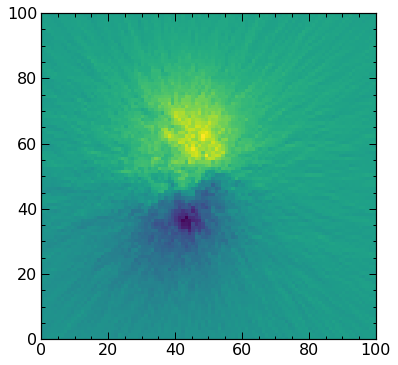

In [374]:
plt.figure()
plt.pcolor(np.flip(Kvals_polar.sum(axis=1)) - Kvals.sum(axis=2))
plt.show()

In [524]:
Kvals_c = np.array(Kvals_cart.sum(axis=0)).reshape(n_cart)
Kvals_s = np.array(Kvals_spher.sum(axis=0)).reshape(n_spher)

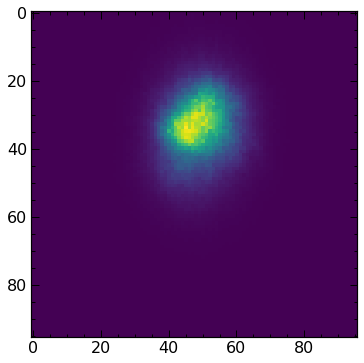

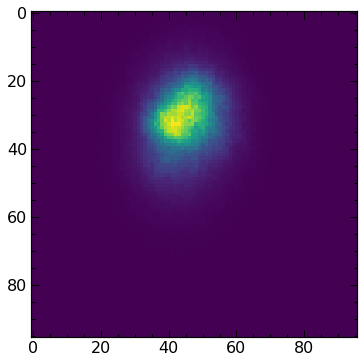

In [554]:
plt.figure()
plt.imshow(np.flip(Kvals_s.sum(axis=1).T, axis=1)**2**2)
plt.show()

plt.figure()
plt.imshow(np.flip(Kvals_c.sum(axis=2), axis=1).T**2**2)
plt.show()

## Investigate terms

In [521]:
n_cart, vmin_cart, dv_cart, vmax_cart, centers_cart = get_vars(f'{path}/RUNS/2022-05-23b')
n_spher, vmin_spher, dv_spher, vmax_spher, centers_spher = get_vars(f'{path}/RUNS/2022-05-23c')

In [522]:
Kvals_cart = KvalsSparseMethod(pvals, rhat.unmasked.value, vmin_cart, dv_cart, n_cart)
Kvals_spher = KvalsSparseMethod(pvals_polar.value, rhat_polar, vmin_spher, dv_spher, n_spher)

In [401]:
mxl_cart = np.load(f'{path}/RUNS/2022-05-23b/mxl_data.npy', allow_pickle=True).item()
mxl_spher = np.load(f'{path}/RUNS/2022-05-23c/mxl_data.npy', allow_pickle=True).item()

In [408]:
phi0r_cart = (mxl_cart[list(mxl_cart.keys())[-1]].ravel())
phi0r_spher = (mxl_spher[list(mxl_spher.keys())[-1]].ravel())

In [403]:
N = len(pvals)

In [404]:
sigma2_cart = np.array([36.84870706447867, 27.271948256861982, 19.519166693304086])**2
sigma2_spher = np.array([36.76545062433692, 19.51744627671726, 27.271755387816768])**2

In [417]:
-9.108254966513236 - 1.00210873815844 - 0.00565955484497322

-10.11602325951665

In [423]:
print(get_neg_L(phi0r_cart, Kvals_cart, N, 1e-11, dv_cart, n_cart, sigma2_cart))
print(get_neg_L(phi0r_spher, Kvals_spher, N, 1e-11, dv_spher, n_spher, sigma2_spher))

-9.32311105442553 1.00210873815844 0.005843879434705164
10.331063672018674
-9.108254966513236 0.9992852779305849 0.00565955484497322
10.113199799288795


In [413]:
print(np.linalg.norm(get_grad_neg_L(phi0r_cart, Kvals_cart, N, 1e-11, dv_cart, n_cart, sigma2_cart)))
print(np.linalg.norm(get_grad_neg_L(phi0r_spher, Kvals_spher, N, 1e-11, dv_spher, n_spher, sigma2_spher)))

4.403378203819359e-05
1.9377894055547773e-05


In [548]:
vmax_spher

array([ 150.,  100., -100.])

## Calculate Pvals_polar from scratch

In [445]:
l = sample.l
b = sample.b
mul = sample.pm_l_cosb.to(u.km / (u.s * u.kpc), equivalencies=u.dimensionless_angles())
mub = sample.pm_b.to(u.km / (u.s * u.kpc), equivalencies=u.dimensionless_angles())
p = sample.distance.to(u.kpc)

In [448]:
pvals = p.value * np.array([-np.sin(l)*np.cos(b)*mul - np.cos(l)*np.sin(b)*mub,
                      np.cos(l)*np.cos(b)*mul - np.sin(l)*np.sin(b)*mub,
                      np.cos(b)*mub])
rhatvals = np.array([np.cos(b)*np.sin(l), np.cos(b)*np.sin(l), np.sin(b)])

In [478]:
pvals.shape

(129675, 3)

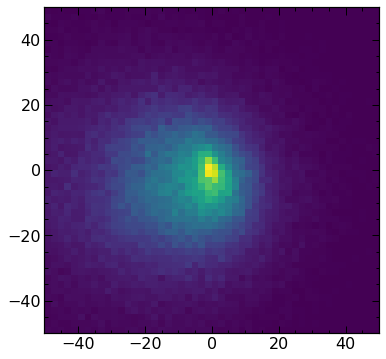

In [499]:
plt.hist2d(pvals[:, 1], pvals[:, 2], bins=50, range=[[-50, 50], [-50, 50]])
plt.show()

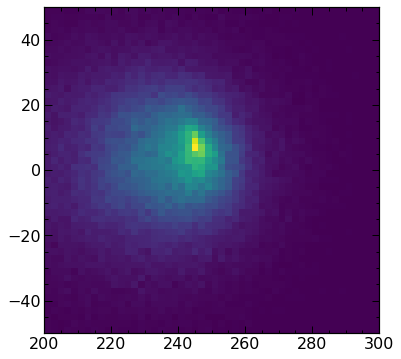

In [500]:
plt.hist2d(-pvals_polar[:, 2].value, pvals_polar[:, 1].value, bins=50, range=[[200, 300], [-50, 50]])
plt.show()

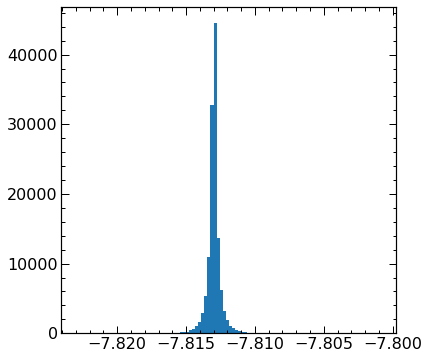

In [520]:
plt.hist(pvals[:, 2] - pvals_polar[:, 1].value, bins=100)
plt.show()

In [515]:
pvals[:, 1] + pvals_polar[:, 0].value

array([-12.87613923, -12.87836029, -12.87500107, ..., -12.87303865,
       -12.8824299 , -12.88887194])

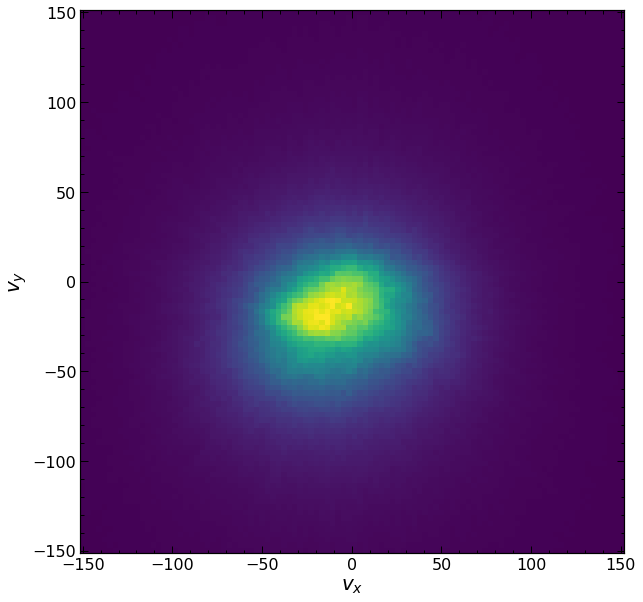

In [282]:
vx = np.linspace(vmin[0], vmax[0], n[0])
vy = np.linspace(vmin[1], vmax[1], n[1])

plt.figure(figsize=(10, 10))
plt.pcolormesh(vx, vy, (Kvals.sum(axis=2).T)**2)
plt.gca().set_aspect('equal')
plt.xlabel('$v_x$')
plt.ylabel('$v_y$')
plt.show()

In [257]:
vsun = coord.Galactocentric().galcen_v_sun.d_xyz

<Quantity [ 12.9 , 245.6 ,   7.78] km / s>

In [258]:
theta = 90*u.deg - sample_polar.lat
phi = sample_polar.lon

In [262]:
R = np.array([[np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)],
              [np.cos(theta)*np.cos(phi), np.cos(theta)*np.sin(phi), -np.sin(theta)],
              [-np.sin(phi), np.cos(phi), np.zeros(len(phi))]]).transpose(2, 0, 1)

In [266]:
vsun_polar = np.einsum('...ikj,...j->...ik', R, vsun)

In [274]:
p = (pvals_polar - vsun_polar)
A = np.identity(3) - rhat_polar[..., np.newaxis] * rhat_polar[..., np.newaxis, :]

In [276]:
phat = p + np.einsum('...ikj,...ij->...ik', A, vsun_polar)

In [278]:
v_mean_polar = np.einsum('...ij,...j->...i', np.linalg.inv(A.mean(axis=-3)), phat.mean(axis=0))

In [279]:
v_mean_polar

<Quantity [  -3.51673112,    9.48440268, -221.55998276] km / s>

In [280]:
v_mean_A

array([ -9.33968667, -23.51585739,  -7.68871402])

In [244]:
sun_gal.representation_type = 'spherical'
sun_gal.differential_type = 'spherical'

theta = 90*u.deg - sun_gal.lat
r = sun_gal.cartesian.x

vr = sun_gal.radial_velocity
vtheta = r*sun_gal.pm_lat.to(u.km / (u.s * u.pc), equivalencies=u.dimensionless_angles())
vphi = r*np.sin(np.deg2rad(theta))*sun_gal.pm_lon.to(u.km / (u.s * u.pc), equivalencies=u.dimensionless_angles())
vsun_polar = (np.array([vr.to(u.km/u.s).value, vtheta.to(u.km/u.s).value, vphi.to(u.km/u.s).value])*u.km/u.s).T

In [127]:
A = np.identity(3) - rhat[..., np.newaxis] * rhat[..., np.newaxis, :]
A_mean_inv = np.linalg.inv(A.mean(axis=-3))

pvals_B = pvals + np.einsum('...ikj,...j->...ik', A, vsun)

pmean_A = pvals.mean(axis=-2)
pmean_B = pvals_B.mean(axis=-2)

v_mean_A = np.einsum('...ij,...j->...i', A_mean_inv, pmean_A)
v_mean_B = np.einsum('...ij,...j->...i', A_mean_inv, pmean_B)

pp_A = pvals - np.einsum('...ikj,...j->...ik', A, v_mean_A)
pp_B = pvalsb - np.einsum('...ikj,...j->...ik', A, v_mean_B)

pp2mean_A = np.mean(np.square(np.abs(pp_A)), axis=-2)
pp2mean_B = np.mean(np.square(np.abs(pp_B)), axis=-2)

In [128]:
v_mean_A, v_mean_B

(array([ -9.33968667, -23.51585739,  -7.68871402]),
 array([  -9.33968667, -268.51585739,   -7.68871402]))

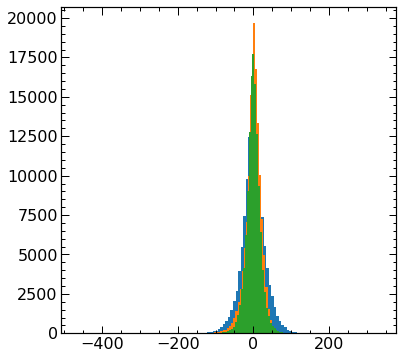

In [107]:
plt.hist(pp_A[:, 0], bins=100)
plt.hist(pp_A[:, 1], bins=100)
plt.hist(pp_A[:, 2], bins=100)
plt.show()

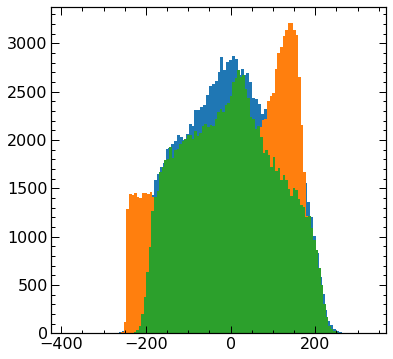

In [108]:
plt.hist(pp_B[:, 0], bins=100)
plt.hist(pp_B[:, 1], bins=100)
plt.hist(pp_B[:, 2], bins=100)
plt.show()

In [ ]:
(Rs * (np.array([50, 50, 50])*v_sun.unit - v_sun)).sum(axis=1)

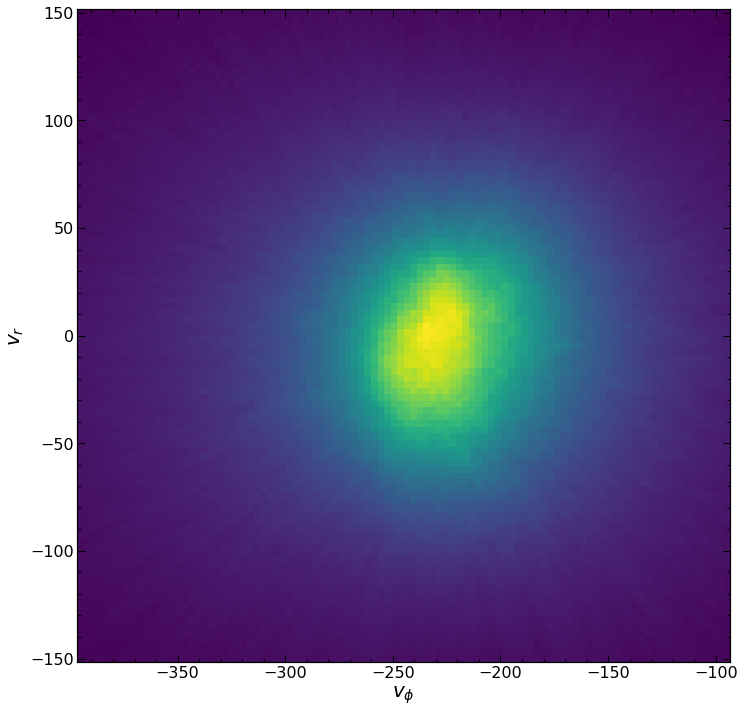

In [349]:
vr = np.linspace(vmin_polar[0], vmax_polar[0], n_polar[0])
vtheta = np.linspace(vmin_polar[1], vmax_polar[1], n_polar[1])
vphi = np.linspace(vmin_polar[2], vmax_polar[2], n_polar[2])

plt.figure(figsize=(12, 12))
plt.pcolormesh(vphi, vr, Kvals_polar.sum(axis=1))
plt.gca().set_aspect('equal')
plt.ylabel('$v_r$')
plt.xlabel('$v_\phi$')
plt.show()

In [ ]:
(np.array([50, 50, 50])*v_sun.unit - v_sun).shape

In [ ]:
gauss_data['ra'] = revert_gauss_sample.ra
gauss_data['dec'] = revert_gauss_sample.dec
gauss_data['parallax'] = revert_gauss_sample.distance.to(u.mas, equivalencies=u.parallax())
gauss_data['dist'] = revert_gauss_sample.distance
gauss_data['pmra'] = revert_gauss_sample.pm_ra_cosdec
gauss_data['pmdec'] = revert_gauss_sample.pm_dec
gauss_data['dr2_radial_velocity'] = revert_gauss_sample.radial_velocity

In [ ]:
vmax = vmin + n*dv

In [ ]:
sample_galcen = sample.transform_to(frame='galactocentric')
x = sample_galcen.cartesian.x.value
y = sample_galcen.cartesian.y.value
z = sample_galcen.cartesian.z.value

# Get solar velocity in Galactocentric frame
v_sun = np.array([sample_galcen.galcen_v_sun.d_x.value,
                  sample_galcen.galcen_v_sun.d_y.value,
                  sample_galcen.galcen_v_sun.d_z.value])*u.km/u.s

r = np.sqrt(x**2 + y**2 + z**2)
theta = np.arccos(z/r)
phi = np.arctan2(y, x)

p += v_sun

pp = np.array([[np.sin(theta)*np.cos(phi)*p[:, 0] + np.sin(theta)*np.sin(phi)*p[:, 1] + np.cos(theta)*p[:, 2]],
              [np.cos(theta)*np.cos(phi)*p[:, 0] + np.cos(theta)*np.sin(phi)*p[:, 1] + -np.sin(theta)*p[:, 2]],
              [-np.sin(phi)*p[:, 0] + np.cos(phi)*p[:, 1]]]).squeeze().T
rp = np.array([[np.sin(theta)*np.cos(phi)*rh[:, 0] + np.sin(theta)*np.sin(phi)*rh[:, 1] + np.cos(theta)*rh[:, 2]],
               [np.cos(theta)*np.cos(phi)*rh[:, 0] + np.cos(theta)*np.sin(phi)*rh[:, 1] + -np.sin(theta)*rh[:, 2]],
               [-np.sin(phi)*rh[:, 0] + np.cos(phi)*rh[:, 1]]]).squeeze().T

In [ ]:
revert_gauss_sample = coord.Galactic(u=x*u.pc,
                                     v=y*u.pc,
                                     w=z*u.pc,
                                     U=uu*u.km/u.s,
                                     V=vv*u.km/u.s,
                                     W=ww*u.km/u.s,
                                     representation_type=coord.CartesianRepresentation,
                                     differential_type=coord.CartesianDifferential)
revert_gauss_sample = revert_gauss_sample.transform_to(coord.ICRS)

In [ ]:
plt.hist2d(uu, vv, bins=50)

In [ ]:
%timeit np.min(pvals[:50, 0])

In [ ]:
%timeit min(pvals[:50, 0])

In [ ]:
sigma2, vmean = calc_sigma2(pvals.value, rhat, True, noniso=True)
phi0r = phi_guess(np.array([0, -200, 0]), np.array([50, 50, 50]), vmin, dv,n).ravel()

In [ ]:
A = np.array([[1, 1, 1], [10, 10, 10], [100, 100, 100]])*np.ones((100, 3, 3))
B = np.array([1, 2, 3])*np.ones((100, 3))

In [290]:
np.abs(Kvals_polar - Kvals_polar.mean()) 

array([[[1.60228019, 1.3867178 , 1.35393863, ..., 1.35302112,
         1.24971741, 1.5007625 ],
        [1.35701634, 1.37086179, 1.56265692, ..., 1.62869246,
         1.53068249, 1.25353968],
        [1.1420367 , 1.14411661, 1.39334674, ..., 1.6191644 ,
         1.52582699, 1.29061255],
        ...,
        [1.41219951, 1.59645442, 1.40267234, ..., 1.51341487,
         1.40188733, 1.31722463],
        [1.68312188, 1.66946747, 1.63335467, ..., 1.00623589,
         1.55286564, 1.3010123 ],
        [1.56803977, 1.310731  , 1.51141771, ..., 1.14224816,
         1.0360311 , 1.36854907]],

       [[1.29172184, 1.29786124, 1.19348763, ..., 1.40675803,
         1.6398152 , 1.24869949],
        [1.46655442, 1.45439465, 1.20447706, ..., 1.26227993,
         1.55521112, 1.16992693],
        [1.2046617 , 1.54502775, 1.41994638, ..., 1.49272018,
         1.21078665, 1.34161075],
        ...,
        [1.54896042, 1.67943747, 1.66999333, ..., 1.41879871,
         1.43862033, 1.0349294 ],
        [1.4

In [ ]:
vbins = [np.linspace(vmin[i], vmax[i], n[i] + 1) for i in range(3)]

In [ ]:
B.shape

In [ ]:
phi_str = ['phi_true', 'phi_est']
alpha = 1e-20
N = len(pvals)
for i, phi in enumerate([phi_true, phi_est]):

    exphi = np.exp(phi)
    Kphi = (Kvals @ exphi.T) # Order all Kphi values in 1D arrays and compute the sum of exp(phi)*K(k|l) for each star
    Kphi_sum_tot = np.log(Kphi[Kphi != 0]).sum() # To make sure we don't get infinities and .sum() gives the double sum in the first term

    phi_unr = np.reshape(phi, n)
    phixhi_sum = (sec_der(phi_unr, sigma2, dv) ** 2).sum()

    t1 = Kphi_sum_tot / N
    t2 = exphi.sum()
    t3 = ((alpha * dv[0] * dv[1] * dv[2]) / 2) * phixhi_sum

    L_tilde = t1 - t2 - t3 # eq. 31 in DB98
    print(f'With {phi_str[i]} : {L_tilde=:.6f}: {t1=:.6f}, {t2=:.6f}, {t3=:.6f}')

In [ ]:
phi = phi_true
exphi = np.exp(phi)
Kphi = (Kvals @ exphi.T)
Kphi_sum_tot = np.log(Kphi[Kphi != 0]).sum()
t1 = Kphi_sum_tot / N

In [ ]:
phi = phi_est
exphi = np.exp(phi)
Kphi = (Kvals @ exphi.T)
Kphi_sum_tot = np.log(Kphi[Kphi != 0]).sum()
t1 = Kphi_sum_tot / N

In [ ]:
pvals_copy = np.zeros_like(pvals)
rhat_copy = np.zeros_like(rhat)
pvals_copy[:, 0], pvals_copy[:, 1], pvals_copy[:, 2] = pvals[:, 1], pvals[:, 0], pvals[:, 2]
rhat_copy[:, 0], rhat_copy[:, 1], rhat_copy[:, 2] = rhat[:, 1], rhat[:, 0], rhat[:, 2]

Kvals = KvalsSparseMethod(pvals.value, rhat, vmin, dv, n)
Karr = np.array(Kvals.sum(axis=0)).reshape(n)

Kvals_copy = KvalsSparseMethod(pvals_copy.value, rhat_copy, vmin, dv, n)
Karr_copy = np.array(Kvals.sum(axis=0)).reshape(n)

In [ ]:
plt.figure()
plt.hist2d(sample.velocity.d_x.value, sample.velocity.d_y.value, bins=n[:-1], range=[[-400, 400], [-400, 400]])
plt.gca().set_aspect('equal')
plt.show()

In [ ]:
plt.figure()
plt.scatter(sample.l, sample.b, s=0.01)
plt.gca().set_aspect('equal')
plt.axis([0, 360, -90, 90])
plt.xlabel('l')
plt.ylabel('b')

In [ ]:
def add_gaussian():
    U1, V1, W1 = rng.multivariate_normal(mean=[200, 200, 0], 
                                         cov=np.identity(3)*np.array([30, 30, 30])**2, 
                                         size=20_000).T
    U2, V2, W2 = rng.multivariate_normal(mean=[200, -200, 0], 
                                         cov=np.identity(3)*np.array([30, 30, 30])**2,
                                         size=20_000).T
    U3, V3, W3 = rng.multivariate_normal(mean=[-200, 200, 0], 
                                         cov=np.identity(3)*np.array([30, 30, 30])**2, 
                                         size=20_000).T
    U4, V4, W4 = rng.multivariate_normal(mean=[-200, -200, 0], 
                                         cov=np.identity(3)*np.array([30, 30, 30])**2, 
                                         size=20_000).T
    U5, V5, W5 = rng.multivariate_normal(mean=[0, 0, 0], 
                                         cov=np.identity(3)*np.array([30, 30, 30])**2,
                                         size=20_000).T

    return np.hstack([U1, U2, U3, U4, U5]), np.hstack([V1, V2, V3, V4, V5]), np.hstack([W1, W2, W3, W4, W5])

uu, vv, ww = add_gaussian()
uu, vv, ww = rng.multivariate_normal(mean=[0, 0, 0], 
                                     cov=np.identity(3)*np.array([30, 30, 30])**2,
                                     size=100_000).T

In [ ]:
theta = np.random.uniform(0, np.pi, len(uu))
phi = np.random.uniform(0,2*np.pi,len(uu))
rho = np.random.uniform(-2000,2000,len(uu))

x = rho*np.cos(phi)*np.sin(theta)
y = rho*np.sin(phi)*np.sin(theta)
z = rho*np.cos(theta)

x = np.random.uniform(-2000,2000,len(uu))
y = np.random.uniform(-2000,2000,len(uu))
z = np.random.uniform(-2000,2000,len(uu))

In [ ]:
gauss_data = QTable()

In [ ]:
C = (A @ B[..., np.newaxis])

In [ ]:
C[1]

In [ ]:
    vr = [(np.array(vbins[i]) - pk[i])/rhat[i] for i in range(3)]

In [ ]:
np.array([])

In [ ]:
ra = range(10)

In [ ]:
lil = scisp.lil_matrix((10, 10))

In [ ]:
lil[0, np.array([])] = np.array([])

In [ ]:
lil

In [ ]:
raise MemoryError('OOM')

In [200]:
vsun, vsun_polar

(<Quantity [ 12.9 , 245.6 ,   7.78] km / s>,
 <Quantity [ 12.91988179,   7.74691299, 245.59919463] km / s>)

In [242]:
vsun_polar, theta

(<Quantity [-12.91988179,  -7.74691299, 245.59919463] km / s>,
 <Angle 90.14673105 deg>)

In [ ]:
5//3

In [ ]:
%timeit np.floor(n/dv)

In [275]:
A.shape

(129675, 3, 3)

In [ ]:
pk = pvals[0].value
rh = rhat[0].value

In [ ]:
vbins = (np.linspace(vmin[i], vmax[i], n[i] + 1) for i in range(3))

vr = [(np.array(vb) - pk[i])/rh[i] for i, vb in enumerate(vbins)]

In [ ]:
vrmax = min(map(np.max, vr))
vrmin = max(map(np.min, vr))

In [ ]:
vrmax, vrmin

In [ ]:
vr = np.concatenate(vr)
vr.sort()

In [229]:
vsun

<Quantity [ 12.9 , 245.6 ,   7.78] km / s>

In [ ]:
vr_prime = (vr[:-1] + vr[1:]) / 2

In [ ]:
pks = np.ones((len(vr_prime), len(pk))) * pk[np.newaxis]
rhats = np.ones((len(vr_prime), len(rh))) * rh[np.newaxis]
vmins = np.ones((len(vr_prime), len(vmin))) * vmin[np.newaxis]
vr_primestack = np.ones((len(vr_prime), 3))*vr_prime[:, np.newaxis]

In [ ]:
v_prime - vmin